In [10]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-f00d1a41-74a2-dc1d-805c-3bec44126b2f)


In [11]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [12]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


print("Number of Cat Images:", len(os.listdir('/tmp/PetImages/Cat/')))
print("Number of Dog Images:", len(os.listdir('/tmp/PetImages/Dog/')))

--2021-03-16 12:41:33--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 2.20.40.101, 2a02:26f0:d7:8a5::e59, 2a02:26f0:d7:88f::e59
Connecting to download.microsoft.com (download.microsoft.com)|2.20.40.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  69.2MB/s    in 13s     

2021-03-16 12:41:46 (58.3 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]

Number of Cat Images: 12501
Number of Dog Images: 12501


In [13]:
sets = [
    '/tmp/catsvdogs',
    '/tmp/catsvdogs/training',
    '/tmp/catsvdogs/testing',
    '/tmp/catsvdogs/training/cats',
    '/tmp/catsvdogs/training/dogs',
    '/tmp/catsvdogs/testing/cats',
    '/tmp/catsvdogs/testing/dogs']

for x in sets:
    try:
        os.mkdir(x)
        print(x, "created")
    except:
        print(x, "failed")

/tmp/catsvdogs failed
/tmp/catsvdogs/training failed
/tmp/catsvdogs/testing failed
/tmp/catsvdogs/training/cats failed
/tmp/catsvdogs/training/dogs failed
/tmp/catsvdogs/testing/cats failed
/tmp/catsvdogs/testing/dogs failed


In [14]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []
    
    for File in os.listdir(SOURCE):
        path = SOURCE + File

        if os.path.getsize(path):
            all_files.append(File)
        else:
            print('{} has 0 length; removed'.format(File))
    
    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)
    
    shuffled = random.sample(all_files, n_files)
    
    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]
    
    for File in train_set:
        copyfile(SOURCE + File, TRAINING + File)
        
    for File in test_set:
        copyfile(SOURCE + File, TESTING + File)


In [15]:
CAT_SOURCE_DIR = r"/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = r"/tmp/catsvdogs/training/cats/"
TESTING_CATS_DIR = r"/tmp/catsvdogs/testing/cats/"
DOG_SOURCE_DIR = r"/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = r"/tmp/catsvdogs/training/dogs/"
TESTING_DOGS_DIR = r"/tmp/catsvdogs/testing/dogs/"
SPLIT_SIZE = .9

split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, SPLIT_SIZE)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, SPLIT_SIZE)

print( "Number of Training Cat Images: " , len(os.listdir('/tmp/catsvdogs/training/cats/')))
print( "Number of Training Dog Images: " , len(os.listdir('/tmp/catsvdogs/training/dogs/')))
print( "Number of Testing Cat Images: " , len(os.listdir('/tmp/catsvdogs/testing/cats/')))
print( "Number of Testing Dog Images: " , len(os.listdir('/tmp/catsvdogs/testing/dogs/')))

666.jpg has 0 length; removed
11702.jpg has 0 length; removed
Number of Training Cat Images:  12376
Number of Training Dog Images:  12379
Number of Testing Cat Images:  2376
Number of Testing Dog Images:  2379


In [16]:
model = tf.keras.models.Sequential()

model.add( tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add( tf.keras.layers.MaxPooling2D(2,2))
model.add( tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add( tf.keras.layers.MaxPooling2D(2,2))
model.add( tf.keras.layers.Conv2D(64, (2,2), activation='relu'))
model.add( tf.keras.layers.MaxPooling2D(2,2))
model.add( tf.keras.layers.Flatten())
model.add( tf.keras.layers.Dense(512, activation='relu'))
model.add( tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 35, 35, 64)        8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [17]:
TRAINING_DIR = '/tmp/catsvdogs/training'
train_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size = 64,
    class_mode = 'binary',
    target_size = (150, 150))

Found 24753 images belonging to 2 classes.


In [18]:
VALIDATION_DIR = '/tmp/catsvdogs/testing'
validation_datagen = ImageDataGenerator(
    rescale = 1 / 255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size = 64,
    class_mode = 'binary',
    target_size = (150, 150))

Found 4755 images belonging to 2 classes.


In [19]:
history = model.fit_generator(train_generator, epochs = 15, verbose = 1, validation_data = validation_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
262/387 [===================>..........] - ETA: 54s - loss: 0.8726 - acc: 0.5540

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

387/387 [==============================] - 201s 518ms/step - loss: 0.8146 - acc: 0.5714 - val_loss: 0.6175 - val_acc: 0.6601
Epoch 2/15
387/387 [==============================] - 201s 520ms/step - loss: 0.5987 - acc: 0.6741 - val_loss: 0.5498 - val_acc: 0.7190
Epoch 3/15
387/387 [==============================] - 201s 520ms/step - loss: 0.5650 - acc: 0.7108 - val_loss: 0.5576 - val_acc: 0.7020
Epoch 4/15
387/387 [==============================] - 201s 520ms/step - loss: 0.5327 - acc: 0.7308 - val_loss: 0.5132 - val_acc: 0.7453
Epoch 5/15
387/387 [==============================] - 200s 518ms/step - loss: 0.5201 - acc: 0.7415 - val_loss: 0.5069 - val_acc: 0.7508
Epoch 6/15
387/387 [==============================] - 200s 517ms/step - loss: 0.5119 - acc: 0.7504 - val_loss: 0.5094 - val_acc: 0.7552
Epoch 7/15
387/387 [==============================] - 199s 513ms/step - loss: 0.5027 - acc: 0.7549 - val_loss: 0.5064 - val_acc: 0.7544
Epoch 8/15
387/387 [==============================] - 200s 

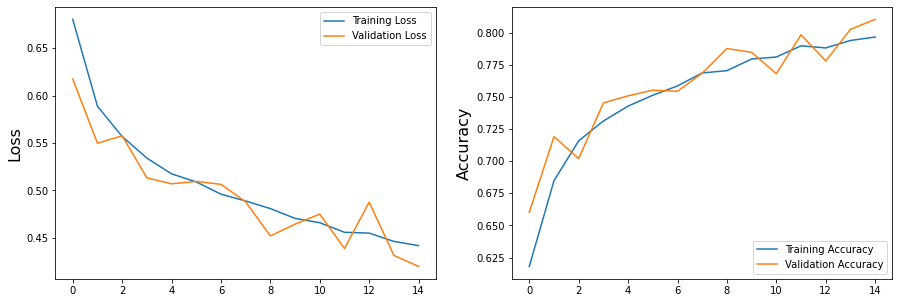

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Saving download.jpg to download.jpg

It is a Dog


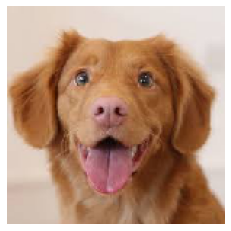

In [21]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  plt.figure()
  plt.imshow(img)
  plt.grid(False)
  plt.axis(False)

  if classes[0]>0.5:
    print("\nIt is a Dog")
  else:
    print("\nIt is a Cat")